In [ ]:
%matplotlib inline

This journal is based heavily off of the one found in the tutorial here https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. 
For a more comprehensive introduction, you can go through the 60 minute blitz, which this tutorial is a part of https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html. 


Training a Classifier
=====================


In this notebook, you will have an example of how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.
We download the CIFAR10 datasets, and set up our dataloaders.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



Shape of images tensor: torch.Size([4, 3, 32, 32])


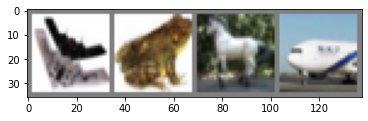

plane  frog horse plane


In [76]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('Shape of images tensor: {}'.format(images.size()))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

The format of `images` is a tensor of size `[4, 3, 32, 32]`. The first dimension is the "batch size", so we can see here that the batch of images contains 4 images. The second dimension is the color channels, where we have RGB colors, and the 3rd and 4th channels are height and width, respectively. 

### 2. Define a Convolutional Neural Network

Here, we have a small convolutional neural network. In `__init__`, we define each individual layer, and in `__forward__`, we pass our data through the layers. To learn more about each layer, go to documentation here https://pytorch.org/docs/stable/nn.html. 



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum optimizer.



In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

An `epoch` defines one pass through the dataset. Therefore, we see that we loop through the dataset twice, and in each loop, we iterate through the batches of data, calculates gradients w.r.t our model weights with `loss.backwards()`, and then updates our weights through the optimizer with `optimizer.step()`. 
Note: This will take a few minutes, maybe longer depending on your machine.

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.177
[1,  4000] loss: 1.846
[1,  6000] loss: 1.685
[1,  8000] loss: 1.580
[1, 10000] loss: 1.505
[1, 12000] loss: 1.462
[2,  2000] loss: 1.390
[2,  4000] loss: 1.362
[2,  6000] loss: 1.355
[2,  8000] loss: 1.293
[2, 10000] loss: 1.306
[2, 12000] loss: 1.241
Finished Training


### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



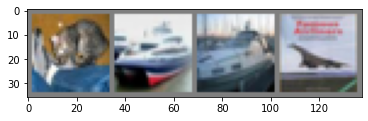

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [10]:
outputs = net(images)
print(outputs)

tensor([[-1.2395, -2.9519,  1.4782,  2.5639, -0.3823,  1.5156,  0.8054, -0.2513,
         -0.5390, -1.6466],
        [ 4.3612,  5.5517, -2.0414, -2.9532, -2.7606, -4.1457, -4.4223, -4.9635,
          6.6436,  2.6338],
        [ 2.9248,  2.5592, -0.7156, -1.4699, -1.6235, -2.1759, -3.2623, -3.2941,
          4.4099,  1.2484],
        [ 4.0968,  0.7252,  0.2868, -1.7185, -0.1150, -2.5318, -3.3648, -2.8139,
          4.5167, -0.4785]], grad_fn=<AddmmBackward>)


The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 68 %
Accuracy of  bird : 50 %
Accuracy of   cat : 25 %
Accuracy of  deer : 41 %
Accuracy of   dog : 37 %
Accuracy of  frog : 64 %
Accuracy of horse : 73 %
Accuracy of  ship : 73 %
Accuracy of truck : 51 %


## Lower the accuracy of model through data manipulation

From our example above, we see that our model does a pretty good job of classifying. You can see that here.

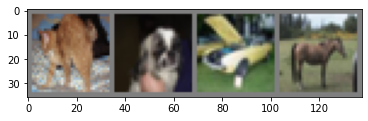

GroundTruth:    cat   dog   car horse
Predicted:    cat   dog  deer horse


In [25]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Now it's your turn to make some changes. Play around with modifying this input by changing the function. You can do things such as zeroing out parts of the image, or adding gaussian noise. How do these changes affect output?

In [81]:


def modify_input(images):
    # We clone the images so that making changes to modified_images doesn't change the original set of images
    modified_images = images.clone().detach()
    t = torchvision.transforms.ColorJitter(contrast=1)
    modified_images.transform = t
    transform(modified_images)
        
        #histogram equalization:
        
        
    '''
    USE THIS SECTION TO MAKE MODIFICATIONS TO modified_images
    '''
    return modified_images

In [82]:
import cv2
modified_images = modify_input(images)

# print images
imshow(torchvision.utils.make_grid(modified_images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(modified_images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>